`Prediction of the price of houses given their characteristics`

**Introduction**
* Each variable in the dataset describes the characteristics of the houses.
* The objective is to predict the price of the house given the independent variables.

**Index**
+ [1. Variable description](#M1)
+ [2. Data Wrangling](#M2)
+ [3. Analysis of the target variable](#M3)
+ [4. Correlation and association](#M4)
+ [5. Variable normalization](#M5)
+ [6. Grouping and encoding of values](#M6)
+ [7. Concatenation of coded variables](#M7)
+ [8. Model RL](#M8)
+ [9. Model Errors](#M9)
+ [10. Coeff. Determination](#M10)
+ [11. Model setting](#M11)

In [1]:
# Import libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
def identify_nulls(var):
    # Nulls and unique values of variables.
    var_nulls = sum(df[var].isnull())
    print(f'{var} has {var_nulls} nulls.')
    var_values = df[var].unique()
    print(f'Unique {var} values are: ', *var_values, sep = ", ")
    print('')

def frec_most_repeated_value(col):
    # Grouping of variables in values = 0 and rest of values
    # Calculation of the relative frequency of the value 0 and the rest.
    cond = np.where(df[col] < 1, True, False)
    df1 = pd.DataFrame(cond).value_counts(normalize = True)
    print(f'For {col}, True: {df1[1]:.3f}, False: {df1[0]:.3f}')

def replacing_outliers_by2ndmax(col, limit_number):
    # Replacement of outliers by the next maximum.
    max_allowed = df[df[col] < limit_number][col].max()
    df[col] = df[col].apply(lambda x: max_allowed if x > limit_number
                           else x)
    
def cramers_v(x, y):
    # Correlation between qualitative variables with Cramers V.
    # Cramers'V is a measure of association between 2 nominal variables, giving a value [0,1].
    # It is based on the Pearson Chi-square statistic.
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def eta_squared(x,y):
    # This square shows the total variation in Y, the proportion that can be attributed to a specific X.
    # To be used to see the relationship between quantitative and qualitative variables.
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

In [3]:
# Creation of dataframe.
data1 = pd.read_csv('train.csv')
data2 = pd.read_csv('test.csv')
r_data2 = pd.read_csv('best_submission.csv')
data2 = pd.merge(data2,r_data2,on='Id')
df = pd.concat([data1, data2], sort=False).reset_index()

### <a name="M1">1. Description of variables</a>

**SalePrice target variable**: house price.

**Meaning of continuous numerical variables**:
* *LotFrontage*: street feet belonging to the property.
* *LotArea*: Total area of the land property in square feet.
* *MasVnrArea* - Wall construction area in square feet.
* *BsmtFinSF1* - Type 1 basement finished area quality.
* *BsmtFinSF2*: quality of the second finished area (if any) of the type 2 basement.
* *BsmtUnfSF* - Square feet of unfinished basement area.
* *TotalBsmtSF* - Square footage of basement area.
* *1stFlrSF* - First floor square footage.
* *2ndFlrSF* - Second floor square footage.
* *GarageArea* - Square footage of the size of the garage.
* *WoodDeckSF* - Wood deck area in square feet.
* *GrLivArea* - Living area above ground in square feet.
* *OpenPorchSF* - Area of the open porch in square feet.
* *EnclosedPorch* - Area of the enclosed porch in square feet.
* *3SsnPorch* - Three station porch area in square feet.
* *ScreenPorch* - Screen porch area in square feet.
* *MiscVal* - Dollar value of miscellaneous features.
* *LowQualFinSF* - Square footage with low quality finish (all floors).
* *PoolArea* - Pool area in square feet
* *MiscVal*: Dollar value of miscellaneous attributes.
* *SalePrice*: price of the house.

**Meaning of discrete numerical variables**:
* *FullBath*: full baths above ground.
* *HalfBath*: half baths above ground.
* *BsmtFullBath* - Full baths in basement.
* *BsmtHalfBath* - Half full baths in basement.
* *BedroomAbvGr* - Above ground bedrooms (excludes basement bedrooms).
* *TotRmsAbvGrd* - Rooms above ground level (does not include bathrooms).
* *Fireplaces*: number of fireplaces.
* *GarageCars*: size of the garage in car capacity.
* *GarageYrBlt*: year of construction of the garage.
* *YearBuilt*: year of construction.
* *YearRemodAdd*: remodeling date (same as construction date if there are no remodels or additions).
* *YrSold*: year sold.
* *MoSold*: month sold.
* *KitchenAbvGr*: above-ground kitchens.

**Meaning of ordinal categorical variables**:
* *LotShape*: property shape (regular or irregular).
* *LandSlope:* pending property.
* *LandContour*: flatness of the property.
* *OverallQual*: note of the materials and finish of the house.
* *OverallCond*: note of the condition of the house in general.
* *ExterQual*: evaluates the quality of the exterior material.
* *ExterCond*: evaluates the current condition of the exterior material.
* *BsmtQual*: evaluates the height of the basement.
* *BsmtCond*: assesses the condition of the basement.
* *BsmtExposure*: refers to garden level walls.
* *HeatingQC*: heating quality and condition.
* *KitchenQual*: kitchen quality.
* *Functional*: functionality of the house.
* *FireplaceQu*: fireplace quality.
* *GarageFinish*: interior finish of the garage.
* *GarageQual*: garage quality.
* *GarageCond*: condition of the garage.
* *Utilities*: type of utilities available.
* *BsmtFinType1*: quality of finished basement area.
* *BsmtFinType2*: quality of the second finished area (if present).
* *CentralAir*: central air conditioning
* *PavedDrive*: paved driveway.

**Meaning of nominal categorical variables**:
* *MSZoning* - Identifies the general zoning classification of the sale.
* *LotConfig*: property configuration.
* *Neighborhood*: neighborhoods.
* *Condition1*: proximity to various conditions.
* *BldgType*: type of housing.
* *HouseStyle*: house style.
* *RoofStyle*: roof style.
* *Exterior1st*: exterior cladding of the house.
* *Exterior2nd*: exterior cladding of the house if there is more than one material.
* *MasVnrType*: masonry cladding type.
* *Foundation*: type of foundation.
* *Electrical*: electrical system.
* *GarageType*: type of garage.
* *SaleType*: type of sale.
* *SaleCondition*: condition of the sale.
* *MSSubClass*: the class of the building.
* *Street*: type of road access
* *Condition2*: proximity to the main road or rail (if a second is present).
* *RoofMatl*: roof material.
* *Heating*: type of heating.

### <a name="M2">2. Data Wrangling</a>

In [4]:
# Variable to categorical nominal transformation, its true nature.
df.MSSubClass = df.MSSubClass.apply(lambda x: str(x))

#### 2.1. Null value handling

In [5]:
# Percentage of nulls for each variable.
per_nulls = df.isnull().sum()[df.isnull().sum() > 0]\
    .sort_values(ascending = False) / len(df) * 100

# At least 45% null.
per_nulls[per_nulls > 45]

PoolQC         99.657417
MiscFeature    96.402878
Alley          93.216855
Fence          80.438506
FireplaceQu    48.646797
dtype: float64

In [6]:
# Elimination of uninformed variables (multitude of nulls)
# and variable Id and index (for not providing information).
drop_cols = per_nulls[per_nulls > 45].index.tolist()
drop_cols.append('Id')
drop_cols.append('index')

df.drop(columns = drop_cols, inplace = True)

In [7]:
# Replacement of null values by the mode of each categorical variable.
cat = df.select_dtypes(include='object')
for var in cat.columns:
    if sum(df[var].isnull()) > 0:
        identify_nulls(var)
        var_mode = df[var].value_counts(normalize = True).index[0]
        # print(f'The mode in {var} is {var_mode}.')
        df[var].fillna(var_mode, inplace = True)
        # print('')

MSZoning has 4 nulls.
Unique MSZoning values are: , RL, RM, C (all), FV, RH, nan

Utilities has 2 nulls.
Unique Utilities values are: , AllPub, NoSeWa, nan

Exterior1st has 1 nulls.
Unique Exterior1st values are: , VinylSd, MetalSd, Wd Sdng, HdBoard, BrkFace, WdShing, CemntBd, Plywood, AsbShng, Stucco, BrkComm, AsphShn, Stone, ImStucc, CBlock, nan

Exterior2nd has 1 nulls.
Unique Exterior2nd values are: , VinylSd, MetalSd, Wd Shng, HdBoard, Plywood, Wd Sdng, CmentBd, BrkFace, Stucco, AsbShng, Brk Cmn, ImStucc, AsphShn, Stone, Other, CBlock, nan

MasVnrType has 24 nulls.
Unique MasVnrType values are: , BrkFace, None, Stone, BrkCmn, nan

BsmtQual has 81 nulls.
Unique BsmtQual values are: , Gd, TA, Ex, nan, Fa

BsmtCond has 82 nulls.
Unique BsmtCond values are: , TA, Gd, nan, Fa, Po

BsmtExposure has 82 nulls.
Unique BsmtExposure values are: , No, Gd, Mn, Av, nan

BsmtFinType1 has 79 nulls.
Unique BsmtFinType1 values are: , GLQ, ALQ, Unf, Rec, BLQ, nan, LwQ

BsmtFinType2 has 80 nulls.
Uni

In [8]:
num = df.select_dtypes(include=np.number)

# Division of the numerical variables by the measure (mean or median) by which the nulls are replaced.
mediana = ['MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageCars']
media = ['LotFrontage','GarageYrBlt','GarageArea']

# Replacement of null by mean or median.
for var in num.columns:
    if var in mediana:
        # Replacement of null by the median.
        df[var].fillna(df.LotFrontage.median(), inplace = True)
    elif var in media:
        # Replacement of null by the mean.
        df[var].fillna(df.LotFrontage.mean(), inplace = True)

In [9]:
# Grouping of variables in numerical, discrete and continuous, and categorical,
# nominal and ordinal.
num_discrete = ['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd',
                'Fireplaces','GarageCars','GarageYrBlt','YearBuilt','YearRemodAdd','YrSold','MoSold']

num_continuous = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
                  '2ndFlrSF','LowQualFinSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
                  '3SsnPorch','ScreenPorch','PoolArea','MiscVal','SalePrice']

cat_ordinal = ['LotShape','Utilities','LandSlope','LandContour','OverallQual','OverallCond','ExterQual','ExterCond',
               'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','CentralAir','KitchenQual',
               'Functional','GarageFinish','GarageQual','GarageCond',
               'PavedDrive']

cat_nominal = ['MSSubClass','MSZoning','Street','LotConfig','Neighborhood',
               'Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st',
               'Exterior2nd','MasVnrType','Foundation','Electrical','Heating','GarageType',
               'SaleType','SaleCondition']

#### 2.2. Correction of erroneous data

In [10]:
# Correction of erroneous data.
# The year of sale is the most current data. There can be no remodeling
# or later constructions.
df[(df.YrSold - df.YearBuilt) < 0][['YrSold','YearBuilt']]

,YrSold,YearBuilt
2549,2007,2008


In [11]:
# Replacement of incorrect year of construction for year of sale of the home.
df.YearBuilt = df.apply(lambda row: row['YrSold'] if row['YearBuilt'] > row['YrSold']
                           else row['YearBuilt'], axis = 1)

In [12]:
# Correction of erroneous data.
# The year of sale is the most current data. There can be no remodeling
# or later constructions.
df[(df.YrSold - df.YearRemodAdd) < 0][['YrSold','YearRemodAdd']]

,YrSold,YearRemodAdd
523,2007,2008
2295,2007,2008
2549,2007,2009


In [13]:
# Replace incorrect year of remodeling by year of home construction.
df.YearRemodAdd = df.apply(lambda row: row['YearBuilt'] if row['YearRemodAdd'] > row['YrSold']
                           else row['YearRemodAdd'], axis = 1)

In [14]:
# Correction of erroneous data.
# The year of sale is the most current data. There can be no remodeling
# or later constructions.
df[(df.YrSold - df.GarageYrBlt) < 0][['YrSold','GarageYrBlt']]

,YrSold,GarageYrBlt
2549,2007,2008.0
2592,2007,2207.0


In [15]:
# Replacement of incorrect year of construction for year of sale of the home.
df.GarageYrBlt = df.apply(lambda row: row['YrSold'] if row['GarageYrBlt'] > row['YrSold']
                           else row['GarageYrBlt'], axis = 1)

In [16]:
# Checking for incorrect data.
# The year of remodeling cannot be less than the year of construction.
df[(df.YearRemodAdd - df.YearBuilt) < 0][['YearBuilt','YearRemodAdd']]

,YearBuilt,YearRemodAdd
1876,2002,2001


In [17]:
# Replacement of incorrect data by year of construction.
df.at[1876,'YearRemodAdd'] = 2002

In [18]:
# Checking for incorrect data.
# The year of remodeling cannot be less than the year of construction.
df[(df.GarageYrBlt - df.YearBuilt) < 0][['YearBuilt','GarageYrBlt']]

,YearBuilt,GarageYrBlt
29,1927,1920.000000
39,1955,69.305795
48,1920,69.305795
78,1968,69.305795
88,1915,69.305795
...,...,...
2893,1916,69.305795
2909,1970,69.305795
2913,1970,69.305795
2914,1970,69.305795


In [19]:
# Replace incorrect years of garage creation with the year of construction
# Of the home.
df.GarageYrBlt = df.apply(lambda row: row['YearBuilt'] if (row['GarageYrBlt'] - row['YearBuilt']) < 0
                          else row['GarageYrBlt'], axis = 1)

#### 23. Creating new variables and deleting variables

In [20]:
# Transformation of year variables into ordinal variables by their
# nature (we assume that the older the home has a lower value).

# Creation of a new numeric column: number of years remodeled.
df['years_remodeled'] = df.YrSold - df.YearRemodAdd
# Elimination of variable YearRemodAdd.
df.drop(['YearRemodAdd'], axis = 1, inplace = True)
# Delete variable from num_discrete list.
num_discrete.remove('YearRemodAdd')
# Inclusion of a new variable years remodeled.
num_discrete.append('years_remodeled')

# Creation of a new numerical column: age of the dwelling.
df['years'] = df.YrSold - df.YearBuilt
# Elimination of variable YearBuilt.
df.drop(['YearBuilt'], axis = 1, inplace = True)
# Delete variable from num_discrete list.
num_discrete.remove('YearBuilt')
# Inclusion of a new variable years remodeled.
num_discrete.append('years')

# Creation of a new numeric column: age of the garage.
df['years_garage'] = df.YrSold - df.GarageYrBlt
# GarageYrBlt variable removal.
df.drop(['GarageYrBlt'], axis = 1, inplace = True)
# Delete variable from num_discrete list.
num_discrete.remove('GarageYrBlt')
# Inclusion of a new variable years remodeled.
num_discrete.append('years_garage')

In [21]:
# Grouping of variables to help the model better predict
# getting a less complex dataset.

# Creation of a new variable of the total quality of the house.
df['Total_Home_Quality'] = (df['OverallQual'] + df['OverallCond']) / 2

# Creation of a new variable with all the feet of the house.
df['Total_sqr_footage'] = (df['TotalBsmtSF'] +
                                 df['1stFlrSF'] + df['2ndFlrSF'])

# Creation of a new variable with all the bathrooms in the house.
df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                               df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

# Creation of a new variable with all the information of the porch.
df['Total_porch_sf'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                              df['EnclosedPorch'] + df['ScreenPorch'] +
                              df['WoodDeckSF'])

In [22]:
# Elimination of the variables that have been grouped from their corresponding lists
# of data types.
# Adhesion of new variables created to their corresponding lists of data types.
cat_ordinal.remove('OverallQual')
cat_ordinal.remove('OverallCond')
cat_ordinal.append('Total_Home_Quality')
num_continuous.remove('TotalBsmtSF')
num_continuous.remove('1stFlrSF')
num_continuous.remove('2ndFlrSF')
num_continuous.append('Total_sqr_footage')
num_discrete.remove('FullBath')
num_discrete.remove('HalfBath')
num_discrete.remove('BsmtFullBath')
num_discrete.remove('BsmtHalfBath')
num_discrete.append('Total_Bathrooms')
num_continuous.remove('OpenPorchSF')
num_continuous.remove('3SsnPorch')
num_continuous.remove('EnclosedPorch')
num_continuous.remove('ScreenPorch')
num_continuous.remove('WoodDeckSF')
num_continuous.append('Total_porch_sf')

# Elimination of the variables that have been grouped from the dataset.
drop_cols = ['OverallQual','OverallCond','1stFlrSF','TotalBsmtSF',
            '2ndFlrSF','FullBath','HalfBath','BsmtFullBath','BsmtHalfBath',
            'OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch','WoodDeckSF']
df.drop(columns = drop_cols, inplace = True)

#### 2.4. Treatment of outliers and more data cleaning in continuous numerics

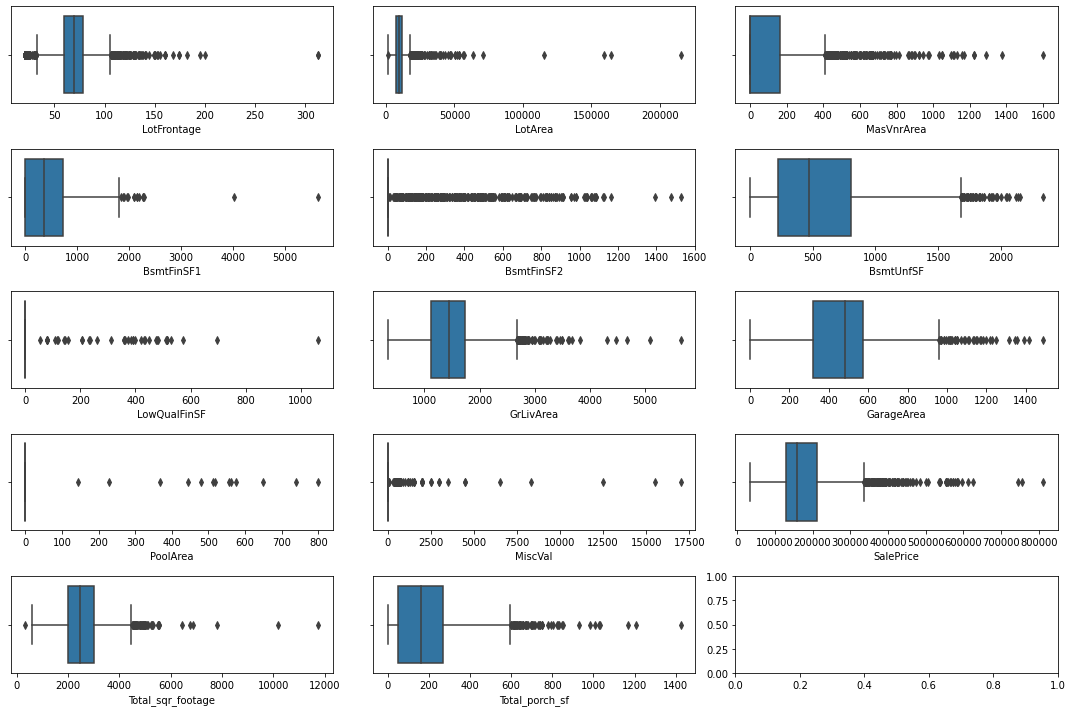

In [23]:
# Boxplots of continuous numeric variables.
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(15,10))

for i, ax in zip(range(14), axes.flat):
    sns.boxplot(df[num_continuous].iloc[:,i], ax=ax)
    fig.tight_layout()

In [24]:
# Variables with a value of 0 in at least 97.5% of the data.
col_valor_unico = []
for col in num_continuous:
    if df[col].quantile(0.975) == 0:
        print(col)
        col_valor_unico.append(col)

# Elimination of variables with a value of 0 in at least 97.5% of the data.
df.drop(col_valor_unico, axis = 1, inplace = True)

# Removal of these list variables num_continuous.
num_continuous = list(set(num_continuous) - set(col_valor_unico))

LowQualFinSF
PoolArea


In [25]:
# 96.5% of the values in MiscVal are 0.
frec_most_repeated_value('MiscVal')

For MiscVal, True: 0.965, False: 0.035


In [26]:
# 88.1% of the values in BsmtFinSF2 are 0.
frec_most_repeated_value('BsmtFinSF2')

For BsmtFinSF2, True: 0.881, False: 0.119


In [28]:
# Binary transformation of the variable BsmtFinSF2 by the high frequency
# relative of 0.
df.BsmtFinSF2 = df.BsmtFinSF2.apply(lambda x: 0 if x == 0 else 1)
# Removal of the variable from the num_continuous list.
num_continuous.remove('BsmtFinSF2')
# Create list of binary variables.
binaries = ['BsmtFinSF2']

In [29]:
# Elimination of the MiscVal variable for having more than a 95% value
# unique 0.
df.drop('MiscVal', axis = 1, inplace = True)
# Removal of the variable from the num_continuous list.
num_continuous.remove('MiscVal')

In [30]:
# Replacement of more accentuated outliers by a maximum value.
replacing_outliers_by2ndmax('Total_sqr_footage', 6000)
replacing_outliers_by2ndmax('Total_porch_sf', 900)
replacing_outliers_by2ndmax('LotFrontage', 300)
replacing_outliers_by2ndmax('LotArea', 100000)
replacing_outliers_by2ndmax('MasVnrArea', 1500)
replacing_outliers_by2ndmax('GrLivArea', 4000)
replacing_outliers_by2ndmax('GarageArea', 1250)
replacing_outliers_by2ndmax('BsmtUnfSF', 2000)
replacing_outliers_by2ndmax('BsmtFinSF1', 3000)

#### 2.5. Distribution of continuous numerical variables after replacing the outliers

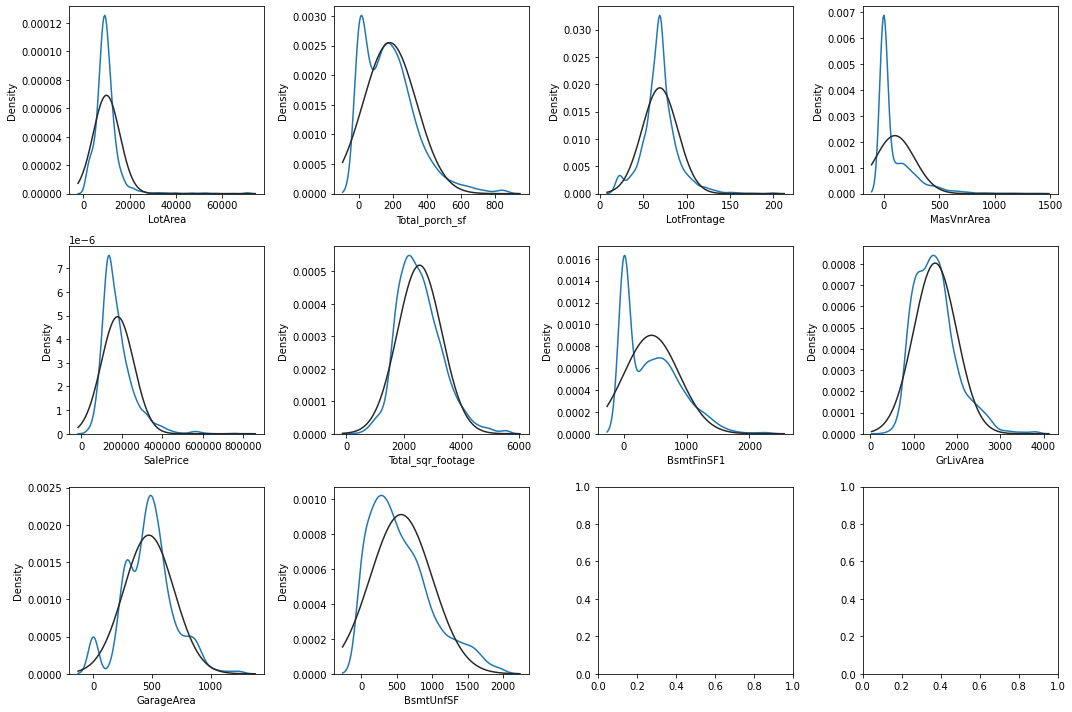

In [31]:
# Distributions of continuous numerical variables after treating outliers.
from scipy.stats import norm

fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(15,10))

for i, ax in zip(range(10), axes.flat):
    sns.distplot(df[num_continuous].iloc[:,i], fit = norm, ax=ax, hist = False)
    fig.tight_layout()

The objective is to get the variables to follow a normal distribution.

Observe how is the distribution of these with a logarithmic transformation.

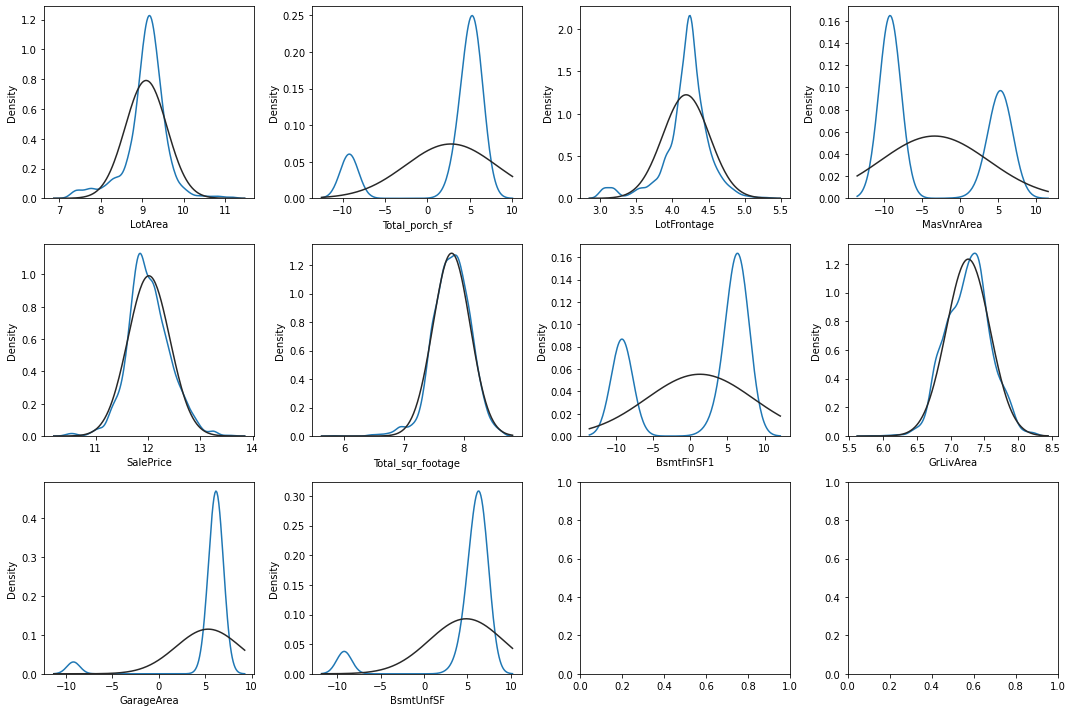

In [32]:
# Logarithmic distributions of continuous numerical variables.
data = df[num_continuous]
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(15,10))

for i, ax in zip(range(10), axes.flat):
    sns.distplot(np.log(data.iloc[:,i].dropna() + 0.0001), fit = norm, ax=ax, hist = False)
    fig.tight_layout()

Now the variables: Total_Sqr_footage, SalePrice and GrLivArea follow a normal distribution.

LotArea is close to a normal distribution.

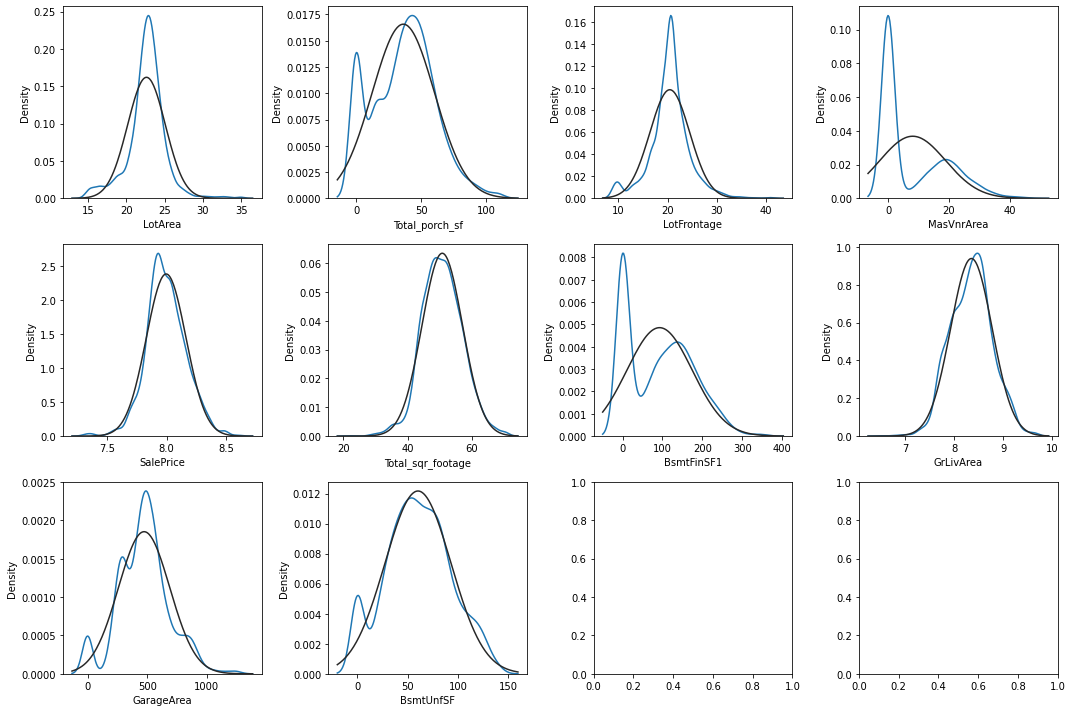

In [33]:
# Box-Cox distributions of continuous numerical variables.
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p

# Box-Cox transformation to normalize data.
data = df[num_continuous]
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(15,10))

for i, ax in zip(range(10), axes.flat):
    sns.distplot(boxcox1p(data.iloc[:,i], boxcox_normmax(data.iloc[:,i] + 1)), fit = norm, ax=ax, hist = False)
    fig.tight_layout()

With this transformation the variables Total_porch_sf, BsmtUnfSF, and LotFrontage are closer to a normal distribution.

#### 2.6. Treatment of outliers and more data cleaning in discrete numerics

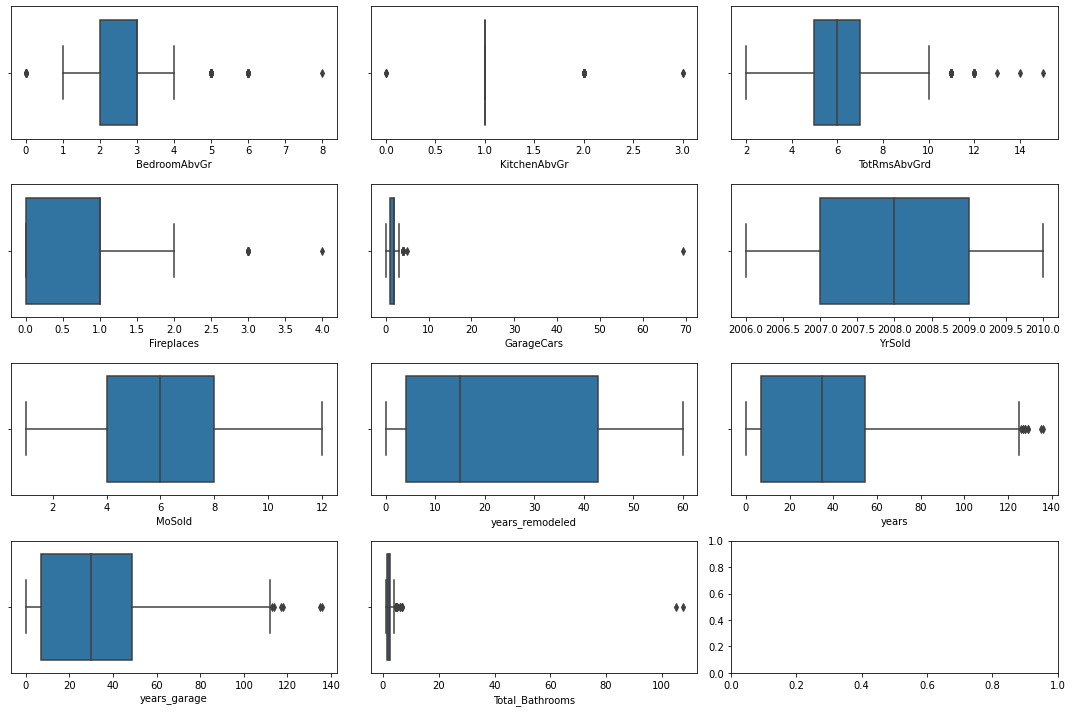

In [34]:
# Boxplots of the discrete numeric variables.
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(15,10))

for i, ax in zip(range(11), axes.flat):
    sns.boxplot(df[num_discrete].iloc[:,i], ax=ax)
    fig.tight_layout()

In [35]:
# Relative frequencies of KitchenAbvGr values.
df['KitchenAbvGr'].value_counts(normalize = True)

1    0.954094
2    0.044193
0    0.001028
3    0.000685
Name: KitchenAbvGr, dtype: float64

In [36]:
# Elimination of variables with more than 95% frequency in a single value.
df.drop(columns = ['KitchenAbvGr'], inplace = True)

# Removing these variables from the num_discrete list.
num_discrete.remove('KitchenAbvGr')

In [37]:
# Relative frequency of Total_Bathrooms values.
df['Total_Bathrooms'].value_counts(normalize = True)

2.000000      0.309010
2.500000      0.191161
1.000000      0.151422
3.000000      0.129496
1.500000      0.100377
3.500000      0.098664
4.000000      0.010620
4.500000      0.005824
5.000000      0.001028
7.000000      0.001028
6.000000      0.000685
107.458693    0.000343
104.958693    0.000343
Name: Total_Bathrooms, dtype: float64

In [38]:
# Grouping of values with at least 4 bathrooms.
df['Total_Bathrooms'] = df['Total_Bathrooms'].apply(lambda x:
                        4 if x > 3 else x)

In [39]:
# Relative frequency of GarageYrBlt values.
df[df.years_garage < df.years_garage.max()].years_garage.max()

135.0

In [40]:
# Replacement of more accentuated outliers by a maximum value.
replacing_outliers_by2ndmax('BedroomAbvGr', 4)
df.BedroomAbvGr = df.BedroomAbvGr.apply(lambda x: 1 if x < 1 else x)
replacing_outliers_by2ndmax('TotRmsAbvGrd', 10)
replacing_outliers_by2ndmax('Fireplaces', 2)
replacing_outliers_by2ndmax('GarageCars', 3)
replacing_outliers_by2ndmax('years_garage', 135)

### <a name="M3">3. Analysis of the objective variable SalePrice with the independent variables</a>
#### 3.1. Relationship *SalePrice* with continuous numerics

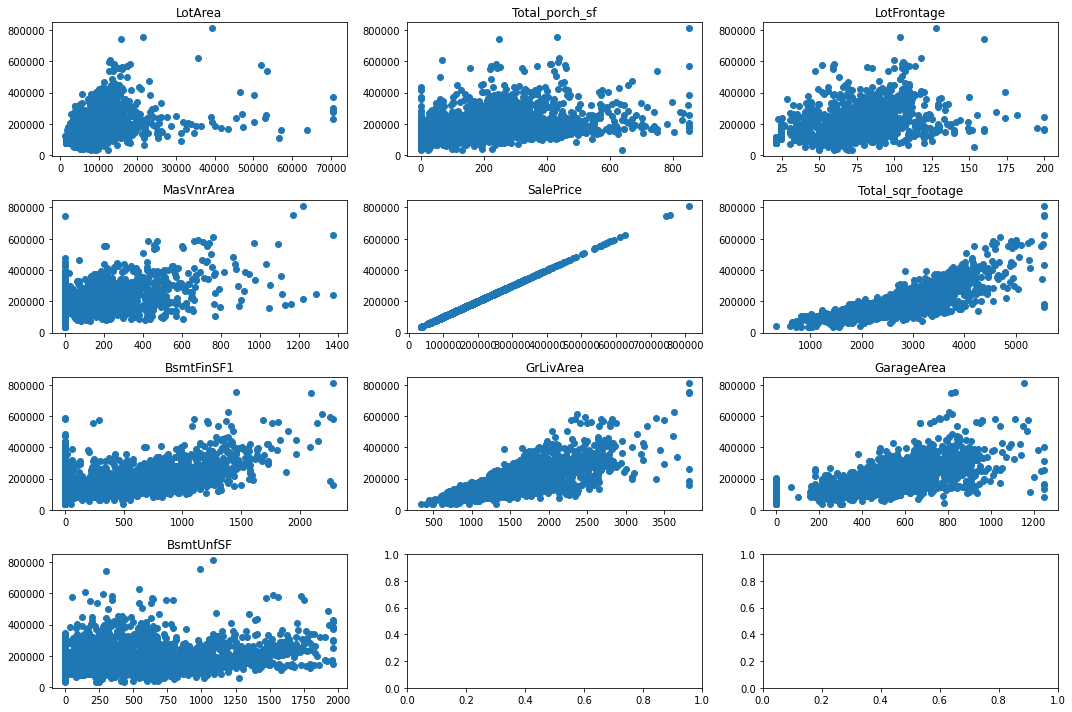

In [41]:
# SalePrice Scatterplot with continuous numerics.
fig, axs = plt.subplots(4,3,figsize=(15,10))
var_num = 0
for ii in range(4):
    for i in range(3):
        if var_num == 10:
            break
        axs[ii,i].scatter(df[num_continuous[var_num]], 'SalePrice', data=df)
        axs[ii,i].set_title(df[num_continuous[var_num]].name)
        var_num += 1
fig.tight_layout()

In [42]:
# Correlation of SalePrice with the rest of continuous numerical variables.
# The grouping of data has led to an improvement in correlation with SalePrice.
df[num_continuous].corr().loc['SalePrice'].sort_values(ascending = False)

SalePrice            1.000000
Total_sqr_footage    0.833818
GrLivArea            0.730795
GarageArea           0.654628
MasVnrArea           0.524362
BsmtFinSF1           0.456826
Total_porch_sf       0.398524
LotFrontage          0.358833
LotArea              0.344714
BsmtUnfSF            0.185458
Name: SalePrice, dtype: float64

In [43]:
# The variables most correlated with SalePrice are stored in this list.
variables_posiblmente_correlacionadas_saleprice = ['Total_sqr_footage','GrLivArea',
                                                 'GarageArea']

#### 3.2. Relationship *SalePrice* with discrete numerics

In [44]:
num_discrete_saleprice = num_discrete.copy()
num_discrete_saleprice.append('SalePrice')

# Correlation of SalePrice with the rest of the discrete numerical variables.
df[num_discrete_saleprice].corr().loc['SalePrice'].sort_values(ascending = False)

SalePrice          1.000000
GarageCars         0.665380
Total_Bathrooms    0.653086
TotRmsAbvGrd       0.512752
Fireplaces         0.476164
BedroomAbvGr       0.168894
MoSold             0.039436
YrSold            -0.030562
years_remodeled   -0.532354
years_garage      -0.544202
years             -0.559337
Name: SalePrice, dtype: float64

In [45]:
# The variables most correlated with SalePrice are stored in this list.
variables_posiblmente_correlacionadas_saleprice.append('GarageCars')
variables_posiblmente_correlacionadas_saleprice.append('Total_Bathrooms')

#### 3.3.Relationship *SalePrice* with binary

In [46]:
binaries_saleprice = binaries.copy()
binaries_saleprice.append('SalePrice')
# Correlation of SalePrice with the rest of the binary variables.
df[binaries_saleprice].corr().loc['SalePrice'].sort_values(ascending = False)

SalePrice     1.000000
BsmtFinSF2   -0.050469
Name: SalePrice, dtype: float64

#### 3.4. Relationship *SalePrice* with categoricals

In [47]:
# List of categorical variables.
cat_total = list(set(df.columns)-set(num_continuous) - set(num_discrete) -set(binaries))
# Attribution to categorical variables the variation of SalePrice.
for var in cat_total:
    total_corr = eta_squared(df[var], df['SalePrice'])
    if total_corr > 0.7:
        print(f'{var}: {round(total_corr,2)}')

### <a name="M4">4. Correlation and association</a>
#### 4.1. Correlation between continuous numerical independent variables

In [48]:
# Correlation between the continuous numerical independent variables.
num_continuous_noSalePrice = num_continuous.copy()
num_continuous_noSalePrice.remove('SalePrice')
for num in num_continuous_noSalePrice:
    values = round(df[num_continuous_noSalePrice].corr().loc[num][(df[num_continuous_noSalePrice].corr().loc[num].sort_values(ascending = False) > 0.6) & (df[num_continuous_noSalePrice].corr().loc[num].sort_values(ascending = False) < 1)],2)
    if values.empty is False:
        print(num)
        print(values)
        print('----------')

Total_sqr_footage
GrLivArea    0.86
Name: Total_sqr_footage, dtype: float64
----------
GrLivArea
Total_sqr_footage    0.86
Name: GrLivArea, dtype: float64
----------


There is high correlation between Total_sqr_footage and GrLivArea.

However, both are quite correlated with *SalePrice*.

#### 4.2. Correlation between discrete and binary numerical independent variables

In [49]:
# Correlation between discrete and binary numerical independent variables
num_discrete_binaries = num_discrete.copy()
for var in binaries:
    num_discrete_binaries.append(var)
for var in num_discrete_binaries:
    tab = df[num_discrete_binaries].corr()
    values = tab[(tab[var] > 0.7) & (tab[var] < 1)][var]
    if values.empty is False:
        print(values)
        print('')

years_garage    0.861582
Name: years, dtype: float64

years    0.861582
Name: years_garage, dtype: float64



There is a high correlation between years and years_garage.

In [50]:
# The most correlated independent variables are stored in this list
variables_independientes_corr_eliminar = ['years_garage']

#### 4.3. Correlation between all numerical independent variables

In [51]:
# Correlation between the numerical independent variables.
for var in df.corr().columns:
    tab = df.corr()
    values = tab[(tab[var] > 0.7) & (tab[var] < 1)][var]
    if values.empty is False:
        print(values)
        print('')

TotRmsAbvGrd         0.797391
SalePrice            0.730795
Total_sqr_footage    0.861057
Name: GrLivArea, dtype: float64

GrLivArea    0.797391
Name: TotRmsAbvGrd, dtype: float64

GarageArea    0.878897
Name: GarageCars, dtype: float64

GarageCars    0.878897
Name: GarageArea, dtype: float64

GrLivArea            0.730795
Total_sqr_footage    0.833818
Name: SalePrice, dtype: float64

years_garage    0.861582
Name: years, dtype: float64

years    0.861582
Name: years_garage, dtype: float64

GrLivArea    0.861057
SalePrice    0.833818
Name: Total_sqr_footage, dtype: float64



In [52]:
# The most correlated independent variables are stored in this list
variables_independientes_corr_eliminar.append('GarageArea')

There is a high correlation between TotRmsAbvGrd and GrLivArea, GarageArea, and GarageCars.

#### 4.4. Association between categorical variables

In [53]:
# Combinations of pairs of the nominal qualitative variables.
pair_nominal = list(itertools.combinations(cat_nominal, 2))
# Correlation for each combination.
for pair in pair_nominal:
    nom_corr = cramers_v(df[pair[0]], df[pair[1]])
    if nom_corr > 0.6:
        print(f'{pair[0]} - {pair[1]}: {round(nom_corr,2)}')

MSSubClass - BldgType: 0.89
MSSubClass - HouseStyle: 0.83
MSZoning - Neighborhood: 0.65
Exterior1st - Exterior2nd: 0.72


MSSubClass is highly correlated with BldgType and HouseStyle.

In [54]:
# The most correlated independent variables are stored in this list
variables_independientes_corr_eliminar.append('MSSubClass')

In [55]:
# Combinations of pairs of ordinal qualitative variables.
pair_ordinal = list(itertools.combinations(cat_ordinal, 2))
# Association for each combination.
for pair in pair_ordinal:
    ord_corr = cramers_v(df[pair[0]], df[pair[1]])
    if ord_corr > 0.6:
        print(f'{pair[0]} - {pair[1]}: {round(ord_corr,2)}')

In [56]:
# Combination of pairs of all the categorical variables.
pair_cat = list(itertools.combinations(cat_total, 2))
# Association for each combination.
for pair in pair_cat:
    cat_corr = cramers_v(df[pair[0]], df[pair[1]])
    if cat_corr > 0.6:
        print(f'{pair[0]} - {pair[1]}: {round(cat_corr,2)}')

HouseStyle - MSSubClass: 0.83
MSSubClass - BldgType: 0.89
MSZoning - Neighborhood: 0.65
Exterior1st - Exterior2nd: 0.72


#### 4.5. Association between categorical and numerical variables

In [57]:
# List of numerical and categorical for later combination between these two classes.
total_num = list(set(df.columns) - set(cat_total))
# Eta square for each numerical with each categorical.
for num in total_num:
    for cat in cat_total:
        total_corr = eta_squared(df[cat], df[num])
        if total_corr > 0.7:
            print(f'{num} - {cat}: {round(total_corr,2)}')

BsmtFinSF2 - BsmtFinType2: 0.99
years - Neighborhood: 0.78


In [58]:
# The most correlated independent variables are stored in this list
variables_independientes_corr_eliminar.append('BsmtFinSF2')

In [59]:
# Elimination of more correlated independent variables.
df.drop(columns = variables_independientes_corr_eliminar, inplace = True)

# Elimination of variables from the identification lists.
num_continuous.remove('GarageArea')
num_discrete.remove('years_garage')
cat_nominal.remove('MSSubClass')
binaries.remove('BsmtFinSF2')

### <a name="M5">5. Normalization of variables</a>
#### 5.1. Normalization of the objective variable SalePrice

In [60]:
# Statistical data of the objective variable.
df[['SalePrice']].describe().T

,count,mean,std,min,25%,50%,75%,max
SalePrice,2919.0,180273.107886,80531.764167,34359.71,128517.5,160000.0,212036.5,810931.0


To do a linear regression the target variable *SalePrice* must follow a normal distribution.

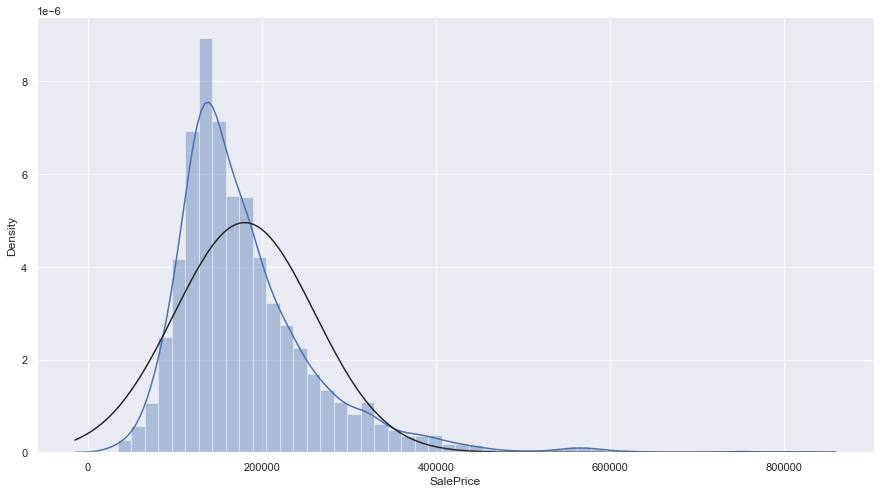

In [61]:
# SalePrice Distribution.
from scipy.stats import norm
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(15,8)})
_= sns.distplot(df.SalePrice, fit = norm)

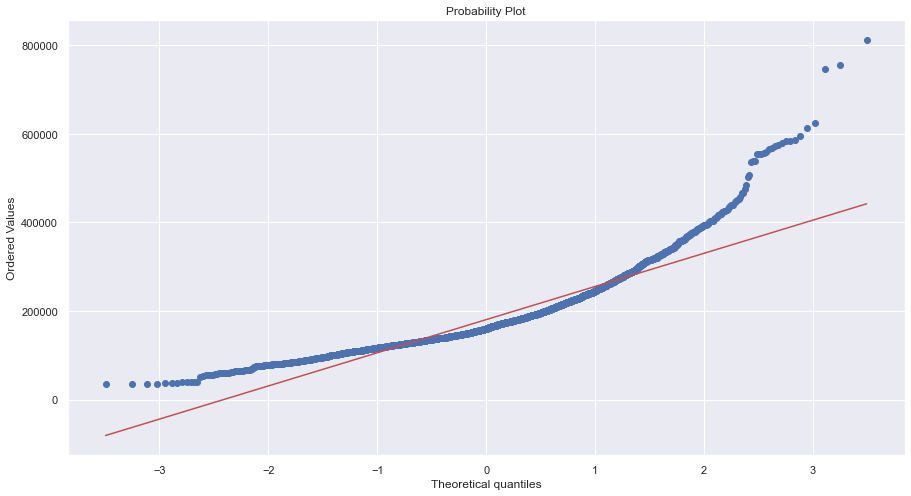

In [62]:
# SalePrice probability plot.
stats.probplot(df['SalePrice'], plot = plt)
plt.show()

*SalePrice* does not follow a normal distribution. It has asymmetry to the right, a peak and does not follow the red diagonal.

In [63]:
# Skewness and kurtosis
print("Skewness: %f" % df['SalePrice'].skew())
print("Kurtosis: %f" % df['SalePrice'].kurt())

Skewness: 1.927295
Kurtosis: 6.544183


You need to transform *SalePrice* to follow a normal distribution.
With this, homoscedasticity is avoided and the variance error will be constant.

By having asymmetry to the right a log transformation could work.

In [64]:
# Log transformation application.
df.SalePrice = np.log(df.SalePrice)

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

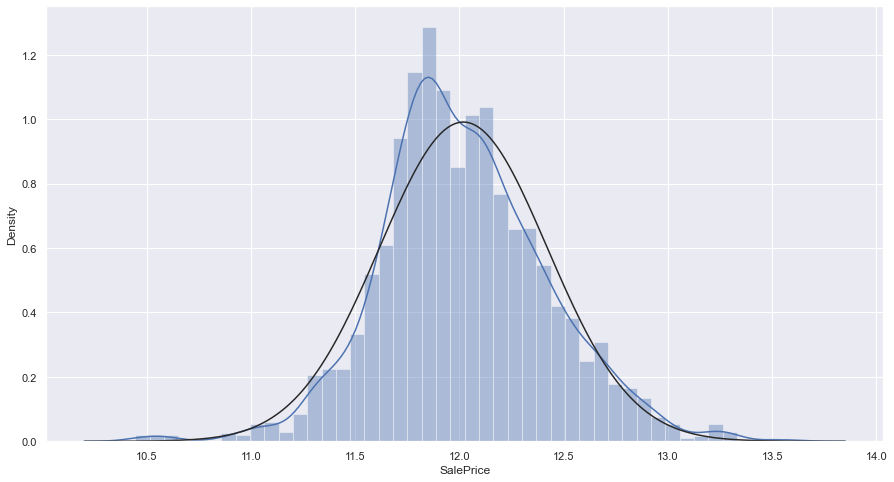

In [65]:
# Histogram that confirms whether the transformed variable
# follows a normal distribution.
sns.distplot(df.SalePrice, fit = norm)

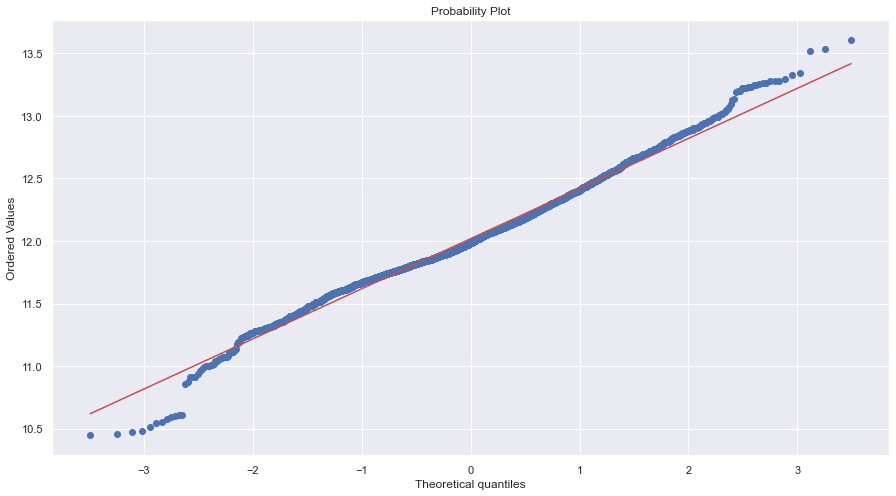

In [66]:
# New SalePrice probability plot.
stats.probplot(df.SalePrice, plot = plt)
plt.show()

#### 5.2. Normalization of independent variables

In [67]:
# Variables to apply the logarithmic transformation.
var_log = ['Total_sqr_footage', 'LotArea']
# Variables to apply the Box-Cox transformation.
var_boxcox = ['Total_porch_sf', 'BsmtUnfSF', 'LotFrontage']

# Application of log transformation for var_log variables.
for var in var_log:
    df[var] = np.log(df[var])
# Boxcox transformation application for var_boxcox variables.
df.Total_porch_sf = boxcox1p(df.Total_porch_sf, boxcox_normmax(df.Total_porch_sf + 1))
df.BsmtUnfSF = boxcox1p(df.BsmtUnfSF, boxcox_normmax(df.BsmtUnfSF + 1))
df.LotFrontage = boxcox1p(df.LotFrontage, boxcox_normmax(df.LotFrontage + 1))

### <a name="M6">6. Grouping of values to obtain better predictor variables</a>
#### 6.1. Nominal categorical variables grouping

In [68]:
# Grouping of data to exceed 2.5% relative frequency.
for var in cat_nominal:
    var_valcounts = df[var].value_counts(normalize = True)
    # list of unique values that do not exceed 2.5% relative frequency.
    values_notrelevant = var_valcounts[var_valcounts < 0.025].index.tolist()
    if len(values_notrelevant) != 0:
        # the smallest value that exceeds 2.5% relative frequency is chosen
        # and is grouped with the values that do not exceed 2.5%.
        minvar_frec = var_valcounts[var_valcounts >= 0.025].index[-1]
        values_notrelevant.append(minvar_frec)
        df[var].replace(values_notrelevant, 'others_and_'+ minvar_frec, inplace = True)

In [69]:
# Removal of variables that have a single unique value after grouping.
for var in cat_nominal:
    if len(df[var].value_counts(normalize = True)) == 1:
        df.drop(var, axis = 1, inplace = True)
        cat_nominal.remove(var)

#### 6.2. Grouping and coding of ordinal categorical variables

In [70]:
# Relative frequency of the variable values.
df.LotShape.value_counts(normalize = True)

Reg    0.636862
IR1    0.331620
IR2    0.026036
IR3    0.005481
Name: LotShape, dtype: float64

In [71]:
# To comply with the 2.5% rule, the form is grouped into Regular and Irregular.
df.LotShape = df.LotShape.apply(lambda x: 1 if x == 'Reg' else 0)

In [72]:
# Relative frequency of the variable values.
df.Utilities.value_counts(normalize = True)

AllPub    0.999657
NoSeWa    0.000343
Name: Utilities, dtype: float64

In [73]:
# Elimination of the Utilities variable as the one present in the relative frequencies is practically a single value.
df.drop('Utilities', axis = 1, inplace = True)
cat_ordinal.remove('Utilities')

In [74]:
# Relative frequency of the variable values.
df.LandSlope.value_counts(normalize = True)

Gtl    0.951696
Mod    0.042823
Sev    0.005481
Name: LandSlope, dtype: float64

In [75]:
# Elimination of the LandSlope variable as the one present in the relative frequencies is practically a single value.
df.drop('LandSlope', axis = 1, inplace = True)
cat_ordinal.remove('LandSlope')

In [76]:
# Relative frequency of the variable values.
df.LandContour.value_counts(normalize = True)

Lvl    0.898253
HLS    0.041110
Bnk    0.040082
Low    0.020555
Name: LandContour, dtype: float64

In [77]:
# To comply with the 2.5% rule it is grouped into whether it is flatter or less.
df.LandContour = df.LandContour.apply(lambda x: 3 if x == 'HLS' or x == 'Low'
                                     else (2 if x == 'Bnk'
                                    else 1))

In [78]:
# Relative frequency of the variable values.
df.Total_Home_Quality.value_counts(normalize = True).sort_index()

1.0    0.000343
1.5    0.000343
2.0    0.001713
2.5    0.002398
3.0    0.005139
3.5    0.009250
4.0    0.020212
4.5    0.045564
5.0    0.125728
5.5    0.214114
6.0    0.278863
6.5    0.187736
7.0    0.077424
7.5    0.021583
8.0    0.005824
8.5    0.003083
9.5    0.000685
Name: Total_Home_Quality, dtype: float64

In [79]:
# To comply with the 2.5% rule, the quality of the house is grouped
# is below average or above.
df.Total_Home_Quality = df.Total_Home_Quality.apply(lambda x: 1 if x < 5.5
                                     else(2 if 5.5 <= x < 6.5
                                     else 3))

In [80]:
# Relative frequency of the variable values.
df.ExterQual.value_counts(normalize = True).sort_index()

Ex    0.036656
Fa    0.011990
Gd    0.335389
TA    0.615964
Name: ExterQual, dtype: float64

In [81]:
# To comply with the 2.5% rule it is grouped into ratings that span more groups.
df.ExterQual = df.ExterQual.apply(lambda x: 1 if x == 'TA' or x == 'Fa'
                                 else (2 if x == 'Gd' else 3))

In [82]:
# Relative frequency of the variable values.
df.ExterCond.value_counts(normalize = True)

TA    0.869476
Gd    0.102432
Fa    0.022953
Ex    0.004111
Po    0.001028
Name: ExterCond, dtype: float64

In [83]:
# To comply with the 2.5% rule it is grouped into ratings that span more groups.
df.ExterCond = df.ExterCond.apply(lambda x: 1 if x == 'Gd' or x == 'Ex'
                                 else 0)

In [84]:
# Unique values of the variable.
df['BsmtQual'].unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

In [85]:
df.BsmtQual = df.BsmtQual.apply(lambda x: 1 if x == 'Fa'
                               else (2 if x== 'TA'
                                else (3 if x == 'Gd'
                                else 4)))

In [86]:
# Relative frequency of the variable values.
df.BsmtCond.value_counts(normalize = True)

TA    0.920863
Gd    0.041795
Fa    0.035629
Po    0.001713
Name: BsmtCond, dtype: float64

In [87]:
# To comply with the 2.5% rule it is grouped into ratings that span more groups.
df.BsmtCond = df.BsmtCond.apply(lambda x: 1 if x == 'Fa' or x == 'Po'
                               else (2 if x == 'TA' else 3))

In [88]:
# Unique values of the variable.
df['BsmtExposure'].unique()

array(['No', 'Gd', 'Mn', 'Av'], dtype=object)

In [89]:
df.BsmtExposure = df.BsmtExposure.apply(lambda x: 1 if x == 'No'
                                       else (2 if x == 'Mn'
                                        else (3 if x == 'Av' else 4)))

In [90]:
# Relative frequency of the variable values.
df.HeatingQC.value_counts(normalize = True)

Ex    0.511477
TA    0.293594
Gd    0.162384
Fa    0.031518
Po    0.001028
Name: HeatingQC, dtype: float64

In [91]:
# To comply with the 2.5% rule it is grouped into ratings that span more groups.
df.HeatingQC = df.HeatingQC.apply(lambda x: 1 if x == 'Fa' or x == 'Po'
                                 else (2 if x == 'TA' 
                               else (3 if x == 'Gd' else 4)))

In [92]:
# Relative frequency of the variable values.
df.CentralAir.value_counts(normalize = True)

Y    0.932854
N    0.067146
Name: CentralAir, dtype: float64

In [93]:
# Conversion to binary variable.
df.CentralAir = df.CentralAir.apply(lambda x: 1 if x == 'Y' else 0)
# Add variable to binary and remove from cat_ordinal.
binaries.append('CentralAir')
cat_ordinal.remove('CentralAir')

In [94]:
# Relative frequency of the variable values.
df.KitchenQual.value_counts(normalize = True)

TA    0.511477
Gd    0.394313
Ex    0.070230
Fa    0.023981
Name: KitchenQual, dtype: float64

In [95]:
# To comply with the 2.5% rule it is grouped into ratings that span more groups.
df.KitchenQual = df.KitchenQual.apply(lambda x: 1 if x == 'TA' or x == 'Fa'
                                     else (2 if x == 'Gd' else 3))

In [96]:
# Relative frequency of the variable values.
df.Functional.value_counts(normalize = True)

Typ     0.931483
Min2    0.023981
Min1    0.022268
Mod     0.011990
Maj1    0.006509
Maj2    0.003083
Sev     0.000685
Name: Functional, dtype: float64

In [97]:
# To comply with the 2.5% rule, it is grouped in functionality from highest to lowest.
df.Functional = df.Functional.apply(lambda x: 1 if x == 'Typ'
                                   else 0)

In [98]:
# Unique values of the variable.
df['GarageFinish'].unique()

array(['RFn', 'Unf', 'Fin'], dtype=object)

In [99]:
df.GarageFinish = df.GarageFinish.apply(lambda x: 1 if x == 'Unf'
                               else (2 if x == 'RFn' else 3))

In [100]:
# Relative frequency of the variable values.
df.GarageQual.value_counts(normalize = True)

TA    0.946557
Fa    0.042480
Gd    0.008222
Po    0.001713
Ex    0.001028
Name: GarageQual, dtype: float64

In [101]:
# To comply with the 2.5% rule it is grouped as good or not good.
df.GarageQual = df.GarageQual.apply(lambda x: 1 if x in ['TA','Gd','Ex']
                                   else 0)

In [102]:
# Relative frequency of the variable values.
df.GarageCond.value_counts(normalize = True)

TA    0.963686
Fa    0.025351
Gd    0.005139
Po    0.004796
Ex    0.001028
Name: GarageCond, dtype: float64

In [103]:
# To comply with the 2.5% rule it is grouped as good or not good.
df.GarageCond = df.GarageCond.apply(lambda x: 1 if x in ['TA','Gd','Ex']
                                   else 0)

In [104]:
# Relative frequency of the variable values.
df.PavedDrive.value_counts(normalize = True)

Y    0.904762
N    0.073998
P    0.021240
Name: PavedDrive, dtype: float64

In [105]:
# Conversion to binary variable.
df.PavedDrive = df.PavedDrive.apply(lambda x: 1 if x == 'Y' else 0)
# Add variable to binary and remove from cat_ordinal.
cat_ordinal.remove('PavedDrive')
binaries.append('PavedDrive')

In [106]:
# Unique values of the variable.
df.BsmtFinType1.unique()

array(['GLQ', 'ALQ', 'Unf', 'Rec', 'BLQ', 'LwQ'], dtype=object)

In [107]:
df.BsmtFinType1 = df.BsmtFinType1.apply(lambda x: 1 if x == 'Unf'
                else (2 if x == 'LwQ'
                else (3 if x == 'Rec'
                else (4 if x == 'BLQ'
                else (5 if x == 'ALQ'
                else 6)))))

In [108]:
# Relative frequency of the variable values.
df.BsmtFinType2.value_counts(normalize = True)

Unf    0.881466
Rec    0.035971
LwQ    0.029805
BLQ    0.023296
ALQ    0.017814
GLQ    0.011648
Name: BsmtFinType2, dtype: float64

In [109]:
# To comply with the 2.5% rule it is grouped as basement quality.
df.BsmtFinType2 = df.BsmtFinType2.apply(lambda x: 
                  1 if x == 'Unf'
                  else (2 if x in ['LwQ', 'Rec', 'BLQ']
                  else 3))

### <a name="M7">7. Nominal encoding and concatenation of encoded variables</a>

In [110]:
# Concatenation of all already encoded data.
df_encode = pd.concat([df[binaries], df[num_continuous]], axis = 1)
df_encode = pd.concat([df_encode, df[num_discrete]], axis = 1)
df_encode = pd.concat([df_encode, df[cat_ordinal]], axis = 1)
df_encode = pd.concat([df_encode, pd.get_dummies(df[cat_nominal])], axis = 1)

### <a name="M8">8. Linear Regression Model Generation</a>

In [111]:
# Separation of independent and dependent variables.
X = df_encode.drop('SalePrice', axis = 1).values  
y = df_encode['SalePrice'].values 

In [112]:
# Selection of 20% test data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [113]:
# Application of the linear model.
reg_mul = linear_model.LinearRegression()
reg_mul.fit(X_train, y_train)

LinearRegression()

### <a name="M9">9. Model errors</a>

In [114]:
# Obtaining the predictions of the model with the training data.
y_predict = reg_mul.predict(X_train)
# Obtaining the predictions of the model with the test data.
y_predict_test = reg_mul.predict(X_test)

# Calculation of training data errors.
mae_train = mean_absolute_error(y_true= np.exp(y_train), y_pred= np.exp(y_predict))
mse_train = mean_squared_error(y_true= np.exp(y_train), y_pred= np.exp(y_predict))
# Calculation of the errors of the test data.
mae_test = mean_absolute_error(y_true= np.exp(y_test), y_pred= np.exp(y_predict_test))
mse_test = mean_squared_error(y_true= np.exp(y_test), y_pred= np.exp(y_predict_test))

print("Mean Absolute Error (MAE) of the training data: {error}".format(error=mae_train))
print("Mean Square Error (MSE) of the training data: {error}".format(error=mse_train))

print("Mean Absolute Error (MAE) of the test data: {error}".format(error=mae_test))
print("Mean Square Error (MSE) of the test data: {error}".format(error=mse_test))

Mean Absolute Error (MAE) of the training data: 10698.896480804382
Mean Square Error (MSE) of the training data: 321336010.71629435
Mean Absolute Error (MAE) of the test data: 12321.315255745369
Mean Square Error (MSE) of the test data: 1121199827.238921


### <a name="M10">10. Determination coefficient</a>
According to the Coefficient of determination, the line fits the data by 94.3%, obtaining a high fit.

In [115]:
# Coefficient of determination.
r2 = reg_mul.score(X, y)
print ("Determination coefficient R^2: {r2}".format(r2=r2))

Determination coefficient R^2: 0.9418157888114704


### <a name="M11">11. Model fit</a>

* Mae training: error 11346.5 dollars.
* Mae test: error 11252.5 dollars.

I have obtained a good model, there is no underfitting or overfitting.
It is a very stable model that generalizes quite well.

However, the mean absolute error is more than $ 11,000.